In [1]:
import csv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# 単語ベクトル化をGridSearchCVで使うのためのクラス
class myVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, method='tfidf', min_df=0.0005, max_df=0.10):
        self.method = method
        self.min_df = min_df
        self.max_df = max_df

    def fit(self, x, y=None):
        if self.method == 'tfidf':
            self.vectorizer = TfidfVectorizer(min_df=self.min_df, max_df=self.max_df)
        else:
            self.vectorizer = CountVectorizer(min_df=self.min_df, max_df=self.max_df)
        self.vectorizer.fit(x)
        return self

    def transform(self, x, y=None):
        return self.vectorizer.transform(x)

In [3]:
# GridSearchCV用パラメータ
PARAMETERS = [
    {
        'vectorizer__method':['tfidf', 'count'], 
        'vectorizer__min_df': [0.0003, 0.0004], 
        'vectorizer__max_df': [0.07, 0.10], 
        'classifier__C': [1, 3],    #10も試したが遅いだけでSCORE低い
        'classifier__solver': ['newton-cg', 'liblinear']},
    ]

# 時間がかかるので下記を省略
#        'vectorizer__min_df': [0.0003, 0.0004, 0.0005, 0.0006], 
#        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},

In [4]:
# ファイル読込
def read_csv_column(col):
    with open('./sentiment_stem.txt') as file:
        reader = csv.reader(file, delimiter='\t')
        header = next(reader)
        return [row[col] for row in reader]    

In [5]:
x_all = read_csv_column(1)
y_all = read_csv_column(0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all)

In [6]:
# 訓練
def train(x_train, y_train, file):
    pipline = Pipeline([('vectorizer', myVectorizer()), ('classifier', LogisticRegression())])
    
    # clf は classificationの略
    clf = GridSearchCV(
            pipline, # 
            PARAMETERS,           # 最適化したいパラメータセット 
            cv = 5)               # 交差検定の回数
    
    clf.fit(x_train, y_train)
    pd.DataFrame.from_dict(clf.cv_results_).to_csv(file)

    print('Grid Search Best parameters:', clf.best_params_)
    print('Grid Search Best validation score:', clf.best_score_)
    print('Grid Search Best training score:', clf.best_estimator_.score(x_train, y_train))
    
    # 素性の重み出力
    output_coef(clf.best_estimator_)
    
    return clf.best_estimator_

In [7]:
# 素性の重み出力
def output_coef(estimator):
    vec = estimator.named_steps['vectorizer']
    clf = estimator.named_steps['classifier']

    coef_df = pd.DataFrame([clf.coef_[0]]).T.rename(columns={0: 'Coefficients'})
    coef_df.index = vec.vectorizer.get_feature_names()
    coef_sort = coef_df.sort_values('Coefficients')
    coef_sort[:10].plot.barh()
    coef_sort.tail(10).plot.barh()

In [8]:
# 評価
def validate(estimator, x_test, y_test):
    
    for i, (x, y) in enumerate(zip(x_test, y_test)):
        y_pred = estimator.predict_proba([x])
        if y == np.argmax(y_pred).astype( str ):
            if y == '1':
                result = 'TP:正解がPositiveで予測もPositive'
            else:
                result = 'TN:正解がNegativeで予測もNegative'
        else:
            if y == '1':
                result = 'FN:正解がPositiveで予測はNegative'
            else:
                result = 'FP:正解がNegativeで予測はPositive'
        print(result, y_pred, x)
        if i == 29:
            break

Grid Search Best parameters: {'classifier__C': 1, 'classifier__solver': 'newton-cg', 'vectorizer__max_df': 0.1, 'vectorizer__method': 'tfidf', 'vectorizer__min_df': 0.0003}
Grid Search Best validation score: 0.7482491245622811
Grid Search Best training score: 0.8676838419209605
CPU times: user 55.7 s, sys: 461 ms, total: 56.2 s
Wall time: 57.7 s


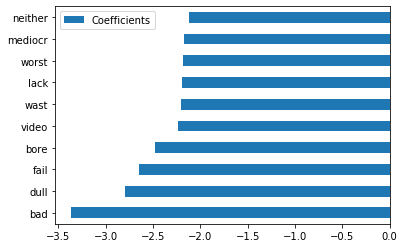

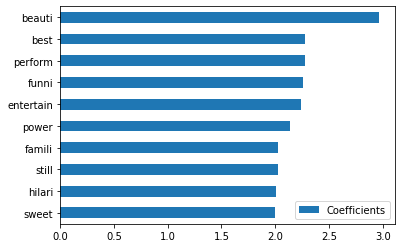

In [9]:
%%time
estimator = train(x_train, y_train, 'gs_result.csv')

In [10]:
%%time
validate(estimator, x_test, y_test)

TN:正解がNegativeで予測もNegative [[0.59697513 0.40302487]] full wrong choic shake head disbelief worri classic oliv parker intend mangl next time
FN:正解がPositiveで予測はNegative [[0.58297706 0.41702294]] provid nail bite suspens credibl charact reli technolog moment techniqu pretenti dialogu
TN:正解がNegativeで予測もNegative [[0.59026702 0.40973298]] classifi altern realiti movi work much better deal realiti
TP:正解がPositiveで予測もPositive [[0.47428752 0.52571248]] ingeni film comedi john malkovich
TP:正解がPositiveで予測もPositive [[0.28947656 0.71052344]] shimmeringli love come age portrait shot art wateri tone blue green brown
TP:正解がPositiveで予測もPositive [[0.19447222 0.80552778]] safe conduct long movi minut fill time drama romanc tragedi braveri polit intrigu partisan sabotag viva le resist
TN:正解がNegativeで予測もNegative [[0.57953836 0.42046164]] movi spend time schneider newcom mcadam even perform interest funnier
TN:正解がNegativeで予測もNegative [[0.56019392 0.43980608]] year old mysteri constantli interrupt elizabeth h